# Module 5 - Wrap-Up Quiz

## Importing Data

In [1]:
import pandas as pd

ames_housing = pd.read_csv(
    "../datasets/ames_housing_no_missing.csv",
    na_filter=False,  # required for pandas>2.0
)
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

Selecting Numerical Features

In [2]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

## Building Models

### Linear Model

We need to preprocess the data with a StandardScaler to scale before to train the linear regressor.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

linear_model = make_pipeline(StandardScaler(), LinearRegression())

## Tree Model

When dealing with decision tree, it is unnecessary to scale the data. So we can directly train our decision tree regressor. The code below shows how to evaluate a decision tree regressor on our regression problem.

In [4]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0)

## Cross-Validation of Both Models

In [5]:
from sklearn.model_selection import cross_val_score

LM_test_scores = cross_val_score(linear_model, data_numerical, target, cv=10, n_jobs=2)
Tree_test_scores = cross_val_score(tree_model, data_numerical, target, cv=10, n_jobs=2)

Fold-to-fold Comparison

In [6]:
print(LM_test_scores > Tree_test_scores)
print(
    "Linear regression is better than decision tree for "
    f"{sum(LM_test_scores > Tree_test_scores)} CV iterations out of 10 folds."
)

[ True  True  True  True  True  True  True  True False  True]
Linear regression is better than decision tree for 9 CV iterations out of 10 folds.


Comparing the individual CV scores, the linear regression model is better than the tree model.

## Fine-Tunning The Tree Depth

We need to use a `GridSearchCV` and pass a `DecisionTreeRegressor`. In addition, we should pass an array with the different values of `max_depth` to evaluate. We give such an example below:

In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate


param_grid = {"max_depth": np.arange(1, 16)}

tree_CV = GridSearchCV(tree_model, param_grid=param_grid, cv=10)

cv_results = cross_validate(tree_CV, data_numerical, target, cv=10, return_estimator=True, n_jobs=2)

### Optimal `max_depth` range

We can inspect the trees trained during the cross-validation to find the values of the `max_depth` parameter.

Checking the best `max_depth` for the 10 estimators,

In [8]:
for estimator in cv_results['estimator']:
    print(estimator.best_params_)

{'max_depth': 5}
{'max_depth': 7}
{'max_depth': 6}
{'max_depth': 6}
{'max_depth': 8}
{'max_depth': 6}
{'max_depth': 7}
{'max_depth': 8}
{'max_depth': 7}
{'max_depth': 6}


Most of the time `max_depth` was in the range 5 to 8.

### Fold-to-fold comparison

#### `random_state=0`

In [9]:
print(cv_results['test_score'] > LM_test_scores)
print(
    "A tree with an optimized depth is better than linear regression for "
    f"{sum(cv_results['test_score'] > LM_test_scores)} CV "
    "iterations out of 10 folds."
)

[False False False False False False False  True  True False]
A tree with an optimized depth is better than linear regression for 2 CV iterations out of 10 folds.


#### `random_state=1`

In [10]:
tree_CV.set_params(estimator__random_state=1)

cv_results = cross_validate(tree_CV, data_numerical, target, cv=10, return_estimator=True)

print(cv_results['test_score'] > LM_test_scores)
print(
    "A tree with an optimized depth is better than linear regression for "
    f"{sum(cv_results['test_score'] > LM_test_scores)} CV "
    "iterations out of 10 folds."
)

[False False False False False False False  True  True False]
A tree with an optimized depth is better than linear regression for 2 CV iterations out of 10 folds.


#### `random_state=42`

In [11]:
tree_CV.set_params(estimator__random_state=42)

cv_results = cross_validate(tree_CV, data_numerical, target, cv=10, return_estimator=True)

print(cv_results['test_score'] > LM_test_scores)
print(
    "A tree with an optimized depth is better than linear regression for "
    f"{sum(cv_results['test_score'] > LM_test_scores)} CV "
    "iterations out of 10 folds."
)

[False False False False False False False  True  True False]
A tree with an optimized depth is better than linear regression for 2 CV iterations out of 10 folds.


The tree model is often performing worse than the linear model regardless of the random state of the tree.

## Models with Cat and Num Data

The code to create the predictive model to handle both categorical and numerical columns is the following:

### Linear Model

In [12]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

categorical_columns_selector = selector(dtype_include=object)
categorical_features = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_features),
     ("numerical", "passthrough", numerical_features)])

linear_model_catnum = make_pipeline(preprocessor, StandardScaler(), LinearRegression())
linear_model_catnum

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exter...
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageCars', 'GarageArea',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch',
                                                   'ScreenPorch', 'PoolArea',
                                                   'MiscVal'])])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### Tree Model

In [13]:
tree_model_catnum = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=7, random_state=0))
tree_model_catnum

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exter...
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageCars', 'GarageArea',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch',
                                                   'ScreenPorch', 'PoolArea',
                                                   'MiscVal'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=7, random_state=0))])

### Comparing Linear and Tree Models

In [14]:
LMCN_test_scores = cross_val_score(linear_model_catnum, data, target, cv=10)
TreeCN_test_scores = cross_val_score(tree_model_catnum, data, target, cv=10)

In [15]:
print(TreeCN_test_scores > LMCN_test_scores)
print(
    "The tree model with categorical features is better than linear regression for "
    f"{sum(TreeCN_test_scores > LMCN_test_scores)} CV "
    "iterations out of 10 folds."
)

[False False False False False False  True  True  True False]
The tree model with categorical features is better than linear regression for 3 CV iterations out of 10 folds.


### Comparing Current and Previous Tree Models

Comparing the tree model with categorical features, with the tree model from  GridSearchCV,

In [19]:
print(TreeCN_test_scores > cv_results['test_score'])
print(
    "The current tree model is better than the previous (GridSearchCV) tree model for\n"
    f"{sum(TreeCN_test_scores > cv_results['test_score'])} CV "
    "iterations out of 10 folds."
)

[ True False  True  True  True  True  True  True  True  True]
The current tree model is better than the previous (GridSearchCV) tree model for
9 CV iterations out of 10 folds.


Changing the random state to 1

In [20]:
tree_model_catnum.set_params(decisiontreeregressor__random_state=1)

TreeCN_test_scores = cross_val_score(tree_model_catnum, data, target, cv=10)

print(TreeCN_test_scores > cv_results['test_score'])
print(
    "The current tree model is better than the previous (GridSearchCV) tree model for\n"
    f"{sum(TreeCN_test_scores > cv_results['test_score'])} CV "
    "iterations out of 10 folds."
)

[ True False  True  True  True  True  True  True  True  True]
The current tree model is better than the previous (GridSearchCV) tree model for
9 CV iterations out of 10 folds.


Changing the random state to 42

In [21]:
tree_model_catnum.set_params(decisiontreeregressor__random_state=42)

TreeCN_test_scores = cross_val_score(tree_model_catnum, data, target, cv=10)

print(TreeCN_test_scores > cv_results['test_score'])
print(
    "The current tree model is better than the previous (GridSearchCV) tree model for\n"
    f"{sum(TreeCN_test_scores > cv_results['test_score'])} CV "
    "iterations out of 10 folds."
)

[ True False  True  True False  True  True  True  True  True]
The current tree model is better than the previous (GridSearchCV) tree model for
8 CV iterations out of 10 folds.


The decision tree performs better when categorical data is added regardless of the random state.

### Plotting Both Scores

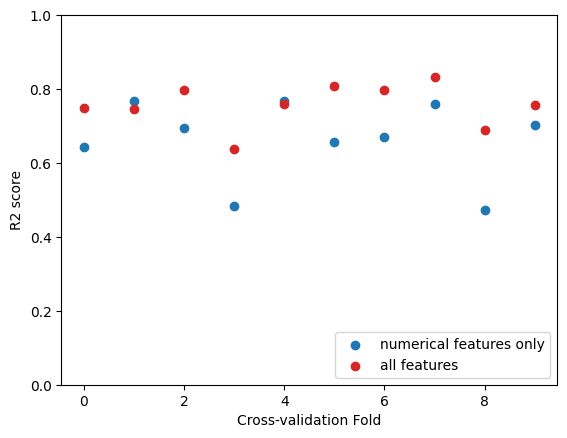

In [23]:
import matplotlib.pyplot as plt

indices = np.arange(len(TreeCN_test_scores))

plt.scatter(indices, cv_results['test_score'], color="tab:blue", label="numerical features only")

plt.scatter(indices, TreeCN_test_scores, color="tab:red", label="all features")

plt.ylim((0, 1))
plt.xlabel("Cross-validation Fold")
plt.ylabel("R2 score")
_ = plt.legend(loc="lower right")